<H1> Customer Analysis <H1>

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Import the dataset
customer_data = pd.read_csv("D:\DA\DA PROJECT\DA DATA\Project 4\Cleaned data\cleaned_customer.csv")
date_data = pd.read_csv("D:\DA\DA PROJECT\DA DATA\Project 4\Cleaned data\cleaned_date.csv")
fact_internet_sales = pd.read_csv("D:\DA\DA PROJECT\DA DATA\Project 4\Cleaned data\cleaned_fact_internet_sales.csv")
geography_data = pd.read_csv("D:\DA\DA PROJECT\DA DATA\Project 4\Cleaned data\cleaned_geography.csv")
product_data = pd.read_csv("D:\DA\DA PROJECT\DA DATA\Project 4\Cleaned data\cleaned_product.csv") 
sales_territory_data = pd.read_csv("D:\DA\DA PROJECT\DA DATA\Project 4\Cleaned data\cleaned_sales_territory.csv") 

# List of DataFrames
df = [customer_data, date_data, fact_internet_sales, geography_data, product_data, sales_territory_data]

# Displey the first few rows of each dataset
for i, df in enumerate(df):
    print(f"DataFrame {i+1}:\n", df.head(), "\n")

DataFrame 1:
    CustomerKey  GeographyKey  FirstName LastName  BirthDate MaritalStatus  \
0        11000            26        Jon     Yang  10/6/1971             M   
1        11001            37     Eugene    Huang  5/10/1976             S   
2        11002            31      Ruben   Torres   2/9/1971             M   
3        11003            11    Christy      Zhu  8/14/1973             S   
4        11004            19  Elizabeth  Johnson   8/5/1979             S   

  Gender                    EmailAddress                Phone  
0      M       jon24@adventure-works.com  1 (11) 500 555-0162  
1      M    eugene10@adventure-works.com  1 (11) 500 555-0110  
2      M     ruben35@adventure-works.com  1 (11) 500 555-0184  
3      F   christy12@adventure-works.com  1 (11) 500 555-0162  
4      F  elizabeth5@adventure-works.com  1 (11) 500 555-0131   

DataFrame 2:
     DateKey FullDateAlternateKey  DayNumberOfWeek EnglishDayNameOfWeek  \
0  20050101           2005-01-01                7

In [3]:
# Meger the DataFrames
df = fact_internet_sales.merge(date_data, left_on='OrderDateKey', right_on= 'DateKey' , how='left')

# Print the column names of the merged DataFrame
print("Column in the merged DataFrame: \n", df.columns.tolist())

Column in the merged DataFrame: 
 ['ProductKey', 'OrderDateKey', 'DueDateKey', 'ShipDateKey', 'CustomerKey', 'PromotionKey', 'CurrencyKey', 'SalesTerritoryKey', 'SalesOrderNumber', 'SalesOrderLineNumber', 'RevisionNumber', 'OrderQuantity', 'UnitPrice', 'ExtendedAmount', 'UnitPriceDiscountPct', 'DiscountAmount', 'ProductStandardCost', 'TotalProductCost', 'SalesAmount', 'TaxAmt', 'Freight', 'CarrierTrackingNumber', 'CustomerPONumber', 'OrderDate', 'DueDate', 'ShipDate', 'DateKey', 'FullDateAlternateKey', 'DayNumberOfWeek', 'EnglishDayNameOfWeek', 'SpanishDayNameOfWeek', 'FrenchDayNameOfWeek', 'DayNumberOfMonth', 'DayNumberOfYear', 'WeekNumberOfYear', 'EnglishMonthName', 'SpanishMonthName', 'FrenchMonthName', 'MonthNumberOfYear', 'CalendarQuarter', 'CalendarYear', 'CalendarSemester', 'FiscalQuarter', 'FiscalYear', 'FiscalSemester']


In [4]:

# Create a column date that reflects the date of the order
df['OrderDate'] = pd.to_datetime(df['FullDateAlternateKey'])

In [5]:
# Assume that the last day of order is the last order date, then +1 day is the next day that is the day to use for calculating re
snapshot_date = df['OrderDate'].max() + pd.Timedelta(days=1)

In [6]:
# Group by customer key and calculate RFM metrics
rfm = df.groupby('CustomerKey').agg({
    'OrderDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'SalesOrderNumber': 'nunique',  # Frequency
    'SalesAmount': 'sum'  # Monetary
})

# Rename the columns
rfm.rename(columns={
    'CustomerKey': 'Customer',
    'OrderDate' : 'Recency',
    'SalesOrderNumber': 'Frequency',
    'SalesAmount': 'Monetary'}, inplace = True
)

# Convert Customer from index to a column   
rfm = rfm.reset_index()
print("RFM DataFrame:\n", rfm.head(100))

# Total row count
print("Total number of customers:", rfm.shape[0])

RFM DataFrame:
     CustomerKey  Recency  Frequency  Monetary
0         11000      271          3   8248.99
1         11001       50          3   6383.88
2         11002      340          3   8114.04
3         11003      264          3   8139.29
4         11004      273          3   8196.01
..          ...      ...        ...       ...
95        11095      218          3   8158.01
96        11096      183          3   8063.04
97        11097      189          3   8099.03
98        11098      105          3     88.96
99        11099      212          3   8215.99

[100 rows x 4 columns]
Total number of customers: 18484


In [7]:
# Segment the customers based on RFM scores
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5, 4, 3, 2, 1])  # Higher recency gets a lower score
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method = 'first'), 5, labels=[1, 2, 3, 4, 5])  # Higher frequency gets a higher score
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, labels=[1, 2, 3, 4, 5])  # Higher monetary gets a higher score



rfm['RFM_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)
# Display the RFM DataFrame with scores
print("RFM DataFrame: \n", rfm.head(100))

RFM DataFrame: 
     CustomerKey  Recency  Frequency  Monetary R_Score F_Score M_Score  \
0         11000      271          3   8248.99       2       5       5   
1         11001       50          3   6383.88       5       5       5   
2         11002      340          3   8114.04       1       5       5   
3         11003      264          3   8139.29       2       5       5   
4         11004      273          3   8196.01       2       5       5   
..          ...      ...        ...       ...     ...     ...     ...   
95        11095      218          3   8158.01       2       5       5   
96        11096      183          3   8063.04       3       5       5   
97        11097      189          3   8099.03       3       5       5   
98        11098      105          3     88.96       4       5       2   
99        11099      212          3   8215.99       2       5       5   

   RFM_Score  
0        255  
1        555  
2        155  
3        255  
4        255  
..       ...  
9

In [8]:
# Create a dictionary to map RFM scores to segments customers

segment_map = {
    'Champions': ['555', '554', '545', '544', '455', '454', '445'],
    'Loyal Customers': ['543', '444', '435', '355', '354', '345', '344', '335'],
    'Potential Loyalist': ['553', '551', '552', '541', '542', '533', '532', '531', '452', '451', '442', '441', 
                           '431', '453', '433', '432', '423', '425', '352', '351', '342', '341', '333', '323'],
    'Recent Customers': ['512', '511', '422', '421', '412', '411', '311'],
    'Promising': ['525', '524', '523', '522', '521', '515', '514', '513', '425', '424', '413', '414', '415', '315'],
    'Customers Needing Attention': ['535', '534', '443', '434', '343', '334', '325', '324'],
    'About To Sleep': ['331', '321', '312', '221', '213'],
    'At Risk': ['255', '254', '245', '244', '253', '252', '243', '242', '235', '234', '225', '224', '153', '152',
                '145', '143', '142', '135', '134', '133', '125', '124'],
    'Can\'t Lose Them': ['155', '154', '144', '214', '215', '115', '114', '113'],
    'Hibernating': ['332', '322', '321', '241', '251', '233', '232', '223', '222', '132', '123', '122', '212', '211'],
    'Lost': ['111', '112', '121', '131', '141', '151']
}

# Function to assign segments based on RFM score
def map_segment(rfm_score):
    for segment, scores in segment_map.items():
        if rfm_score in scores:
            return segment
    return 'Others'

# Apply the mapping function to create a new column for segments
rfm['Segment'] = rfm['RFM_Score'].apply(map_segment)

# Display the RFM DataFrame with segments
print('Data Frame with Segments: \n', rfm.head(100))

Data Frame with Segments: 
     CustomerKey  Recency  Frequency  Monetary R_Score F_Score M_Score  \
0         11000      271          3   8248.99       2       5       5   
1         11001       50          3   6383.88       5       5       5   
2         11002      340          3   8114.04       1       5       5   
3         11003      264          3   8139.29       2       5       5   
4         11004      273          3   8196.01       2       5       5   
..          ...      ...        ...       ...     ...     ...     ...   
95        11095      218          3   8158.01       2       5       5   
96        11096      183          3   8063.04       3       5       5   
97        11097      189          3   8099.03       3       5       5   
98        11098      105          3     88.96       4       5       2   
99        11099      212          3   8215.99       2       5       5   

   RFM_Score             Segment  
0        255             At Risk  
1        555           Ch

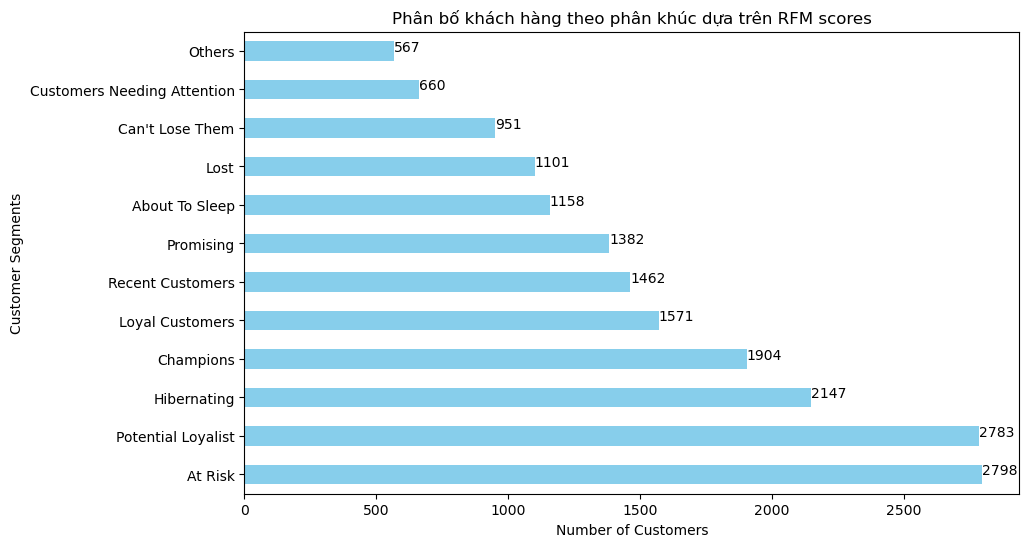

In [9]:
# Visualize statistics of RFM scores
rfm['Segment'].value_counts().plot(kind='barh', figsize = (10, 6), color='skyblue', title = 'Phân bố khách hàng theo phân khúc dựa trên RFM scores')

# Add labels to the bars
plt.xlabel('Number of Customers')
plt.ylabel('Customer Segments')

# Add labels to each bar
for index, value in enumerate(rfm['Segment'].value_counts()):
    plt.text(value, index, str(value))

In [10]:
# Export the RFM DataFrame to a CSV file
rfm.to_csv("D:\DA\DA PROJECT\DA DATA\Project 4\Cleaned data\\rfm.csv", index=False)